In [18]:
import os
import collections
import json
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 20)
pd.options.display.max_rows = 100

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import langid
from src.wimbd_ import WimbdAnalysis, WimbdTasks, display_language_pairs, filter_percentile, load_results

In [20]:
# lang params
N_GRAMS = 2
BASE_DIR = f"./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue"
# LANG_DF_PTH = "./results/n-grams/exp_full/2/examples_dfs_0-shot_common_models.pkl"
LANG_DF_PTH_1 = f"./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/{N_GRAMS}/examples_dfs_0-shot_common_models.pkl"
# LANG_DF_PTH = f"./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/{N_GRAMS}/examples_dfs_0-shot_all_models.pkl"
LANG_DF_PTH = f"./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/{N_GRAMS}/all/lang_dfs_is_allTrue_filter_charsFalse_percentile0_detect_langTrue_filter_entitiesTrue_filter_stopwordsTrue_remove_englishTrue_remove_non_englishFalse.pkl"
LANG_DF_PTH = f"./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/{N_GRAMS}/common/lang_dfs_filter_charsFalse_percentile0_detect_langFalse_filter_entitiesTrue_filter_stopwordsTrue_align_langs0.pkl"
# LANG_DF_PTH = f"./results/n-grams/exp_full/"

BASE_PATH = os.path.join(BASE_DIR, str(N_GRAMS))
BASE_PATH_COMMON = os.path.join(BASE_PATH, "common")
BASE_PATH_ALL = os.path.join(BASE_PATH, "all")
FILTER_CHARS = False
DETECT_LANG = False
PERCENTILE = 0.95
TASK = 'TRANSLATION'

# model params
base_results_path = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/experiment_6_logits_max_4/inference/EleutherAI"
models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m',]

# wmt09
LANGUAGES = ['wmt09-cs-en', 'wmt09-de-en', 'wmt09-fr-en', 'wmt09-es-en', 'wmt09-it-en', 'wmt09-hu-en']

# LANGUAGES = ['wmt09-en-cs', 'wmt09-en-de', 'wmt09-en-fr', 'wmt09-en-es', 'wmt09-en-it', 'wmt09-en-hu',]
TASKS = [task.replace('wmt09-', '') for task in LANGUAGES]

wa = WimbdAnalysis(BASE_PATH, LANGUAGES, N_GRAMS, FILTER_CHARS)
wt = WimbdTasks()

LANGUAGES_STR = "_".join(LANGUAGES)
PLOT_PATH = f"./results/n-grams/exp_full/{N_GRAMS}/plots/{LANGUAGES_STR}_filter_{FILTER_CHARS}"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

In [21]:
bleu_scores = load_results(base_results_path, models, TASK, '0-shot', LANGUAGES)
bleu_scores_0 = bleu_scores[list(bleu_scores.keys())[0]]

In [22]:
bleu_scores['pythia-12b'].keys()

dict_keys(['cs-en', 'de-en', 'fr-en', 'es-en', 'it-en', 'hu-en'])

In [23]:
bleu_scores['pythia-14m']['it-en']

{'bleu': 0.10841678298210985, 'bleu_stderr': 0.014296327695126367}

In [24]:
# lang_dfs_all_filtered = wa.get_lang_dfs(BASE_PATH_ALL, LANGUAGES, filter_chars=True,
#                                         percentile=0.95, detect_lang=False, filter_entities=True)

lang_dfs = pickle.load(open(LANG_DF_PTH, 'rb'))
lang_dfs_1 = pickle.load(open(LANG_DF_PTH_1, 'rb'))

if 'pythia-12b' in lang_dfs:
    lang_df_0 = lang_dfs['pythia-12b']
    lang_df = lang_df_0
else:
    lang_df_0 = lang_dfs[list(lang_dfs.keys())[0]]
    lang_df = pd.concat(lang_dfs).reset_index(drop=True)
    lang_dfs = {model: lang_df for model in models}

lang_dfs = {lang: filter_percentile(df, PERCENTILE) for lang, df in lang_dfs.items()}
lang_dfs_0 = lang_dfs[list(lang_dfs.keys())[0]]
    
# get total samples per language pair
lang_dfs_total_samples = {task: lang_dfs_0[lang_dfs_0['task'] == task]['value'].sum() for task in lang_dfs_0['task'].unique()}
colors = sns.color_palette('hls', len(TASKS))
color_mapping = {lang: color for lang, color in zip(TASKS, colors)}

In [25]:
len(lang_df)

347746

In [26]:
for task in lang_df_0['task'].unique():
    lang_df_task = lang_df_0[lang_df_0['task'] == task]
    print(f"task: {task}")
    print(f"len rows: {len(lang_df_task)}")
    if 'query' in lang_df_task.columns:
        print(f"unique_examples: {len(lang_df_task['query'].unique())}")

task: cs-en
len rows: 41102


['cs-en', 'de-en', 'fr-en', 'es-en', 'it-en', 'hu-en']
model: pythia-12b, task: cs-en, score_key: cs-en
model: pythia-12b, task: de-en, score_key: de-en
model: pythia-12b, task: es-en, score_key: es-en
model: pythia-12b, task: fr-en, score_key: fr-en
model: pythia-12b, task: hu-en, score_key: hu-en
model: pythia-12b, task: it-en, score_key: it-en
model: pythia-6.9b, task: cs-en, score_key: cs-en
model: pythia-6.9b, task: de-en, score_key: de-en
model: pythia-6.9b, task: es-en, score_key: es-en
model: pythia-6.9b, task: fr-en, score_key: fr-en
model: pythia-6.9b, task: hu-en, score_key: hu-en
model: pythia-6.9b, task: it-en, score_key: it-en
model: pythia-2.8b, task: cs-en, score_key: cs-en
model: pythia-2.8b, task: de-en, score_key: de-en
model: pythia-2.8b, task: es-en, score_key: es-en
model: pythia-2.8b, task: fr-en, score_key: fr-en
model: pythia-2.8b, task: hu-en, score_key: hu-en
model: pythia-2.8b, task: it-en, score_key: it-en
model: pythia-1.4b, task: cs-en, score_key: cs-en
m

/tmp/ipykernel_2433563/131168678.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  model_colormap = plt.cm.get_cmap('coolwarm', len(models))


Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/2/plots/lang_scores_XY_pairs_N-grams_2.png


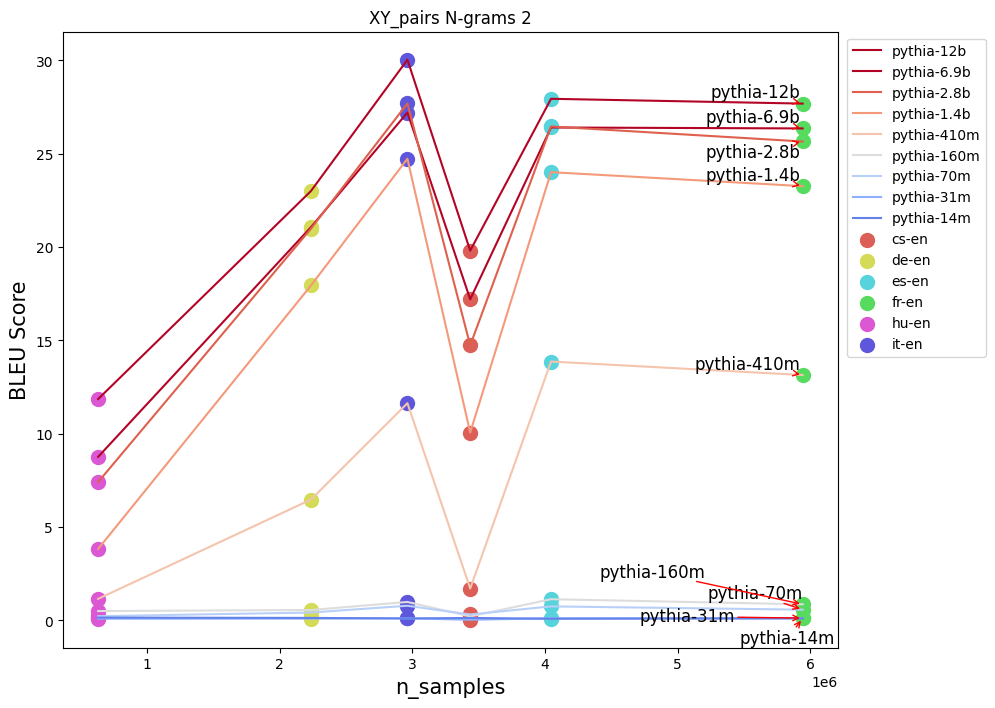

In [27]:
"""
This block is used to display
the language pairs that are available
"""

# for lang, df in lang_dfs_all.items():
#     print(f"{lang}: {len(df)}")

# # display top 100 of each language
# for lang, df in lang_dfs.items():
#     print(f"-------- lang: {lang} --------")
#     df = df.sort_values(by=['value'], ascending=False)
#     print(f"// top 100")
#     display(df.iloc[:100])
#     midpoint = np.median(df['value'])
#     print(f"// mid 100")
#     display(df[df['value'] <= midpoint].iloc[:100])

def get_model_results_from_df(df, scores, metric='bleu'):
    """"
    returns a dict of structure {task: {model:{scores, nsamples}}
    """
    model2score = {}
    dataset2score = {}
    score_keys = list(scores[list(scores.keys())[0]])
    print(score_keys)
    for model, model_results in df.items():
        for task in sorted(score_keys):
            if model not in model2score:
                model2score[model] = {'score': [], 'n_samples': []}
            if task not in dataset2score:
                dataset2score[task] = {'score': [], 'n_samples': []}
            if task not in model_results['task'].unique():
                task_key = task.split('-')
                task_key = f"{task_key[1]}-{task_key[0]}"
            else:
                task_key = task
            task_df = model_results[model_results['task'] == task_key]
            score_key = task
            print(f"model: {model}, task: {task}, score_key: {score_key}")
            task_score = scores[model][score_key]['bleu']
            task_n_samples = task_df['value'].sum()
            model2score[model]['score'].append(task_score)
            model2score[model]['n_samples'].append(task_n_samples)
            dataset2score[task]['score'].append(task_score)
            dataset2score[task]['n_samples'].append(task_n_samples)
    return model2score, dataset2score

def get_task_ngrams_from_df(df):
    first_model = list(df.keys())[0]
    examples = df[first_model] # the ngram vals are same for all models
    tasks = examples['task'].unique()
    task_ngrams = {}
    for task in tasks:
        task_ngrams[task] = {'score': [], 'n_samples': []}
        task_df = examples[examples['task'] == task]
        score = task_df.iloc[0]['bleu']
        # n_samples = 
        task_ngrams[task] = task_df
    return task_ngrams


model2score, dataset2score = get_model_results_from_df(lang_dfs, bleu_scores)
# task_ngrams = get_task_ngrams_from_df(lang_dfs)

# model colormap
model_colormap = plt.cm.get_cmap('coolwarm', len(models))
model_color_mapping = {model: model_colormap(1 - i / len(models)) for i, model in enumerate(models)}

# plot
wa.plot_scores(model2score, dataset2score, color_mapping,
               model_color_mapping, name=f"XY_pairs N-grams {N_GRAMS}")

In [29]:
for task in lang_df['task'].unique():
    lang_df_task = lang_df[lang_df['task'] == task]
    print(f"task: {task}")
    print(f"len rows: {len(lang_df_task)}")
    if 'query' in lang_df_task.columns:
        display(lang_df_task)

task: cs-en
len rows: 82204
task: de-en
len rows: 40836
task: en-fr
len rows: 82510
task: en-es
len rows: 65260
task: en-it
len rows: 56154
task: en-hu
len rows: 20782
